# Structure Representation Computation from Audio Input
### Comparing different sizes to downsample combined matrix

## > Library importing

In [17]:
#Computation
import numpy as np
import scipy
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import cv2

#Data Processing
import sklearn.cluster

#Audio
import librosa
from librosa import display

#System
import glob
import os
import sys

#Pickling
import dill

## > Loading audio

In [18]:
#Choose directory containing audiofiles
directory = '../../test_dataset'

#Read all paths in specified directory
all_filepaths = []
all_names= []
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name) or ('.mp3' in name)):
                filepath = os.path.join(root, name)
                all_filepaths.append(filepath)
                all_names.append(name[:-4])

#Dictionary containing all batches of matrices as described by pipeline documentation in a linearized, sequential format
X = {}

#Load all audiofiles and store in array
all_audio = []
file_no = len(all_filepaths)
for f in range(file_no):
    y, sr = librosa.load(all_filepaths[f], sr=22050, mono=True)
    all_audio.append((y, sr))
    sys.stdout.write("\rLoaded %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    
X["audio"] = all_audio

Loaded 8/8 pieces.

## > Self Similarity for Repetitions

### >> Single-Feature Self Similarity Matrix

In [19]:
#Pipeline of primary features to use to compute self similarity
#{log_power_CQT}

all_logCQT = []

for f in range(file_no):

    #Log-power Constant-Q Transform
    bins_per_oct = 12*3
    n_oct = 7
    CQT = librosa.cqt(y=X["audio"][f][0], sr=X["audio"][f][1], bins_per_octave=bins_per_oct, n_bins=n_oct*bins_per_oct)
    all_logCQT.append(librosa.amplitude_to_db(CQT))

    sys.stdout.write("\rComputed spectral representations for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    
spectral_rep = {"logCQT":all_logCQT}
X["spectral_rep"]=spectral_rep

Computed spectral representations for 8/8 pieces.

### >> Beat Synchronization

In [20]:
X["reduced_spectral_rep"] = {"logCQT_beat":[]}

for f in range(file_no):

    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    for rep in ["logCQT"]:
        X["reduced_spectral_rep"][rep+"_beat"].append(librosa.util.sync(X["spectral_rep"][rep][f], beats, aggregate=np.median))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Short-term History Embedding of spectral representation

In [21]:
steps = 4
X["stacked_spectral_rep"] = {"stacked_logCQT_beat":[]}
for f in range(file_no):
    for rep in ["logCQT_beat"]:
        X["stacked_spectral_rep"]["stacked_"+rep].append(librosa.feature.stack_memory(X["reduced_spectral_rep"][rep][f], steps))
    
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Weighted Recurrence Matrix

In [22]:
knn_no = 3
X["ssm"] = {"ssm_s_logCQT_beat":[]}
for f in range(file_no):
    for rep in ["logCQT_beat"]: 
        X["ssm"]["ssm_s_"+rep].append(librosa.segment.recurrence_matrix(X["stacked_spectral_rep"]["stacked_"+rep][f], width=knn_no, mode='affinity', sym=True))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Timelag filter & Path enhancement

In [23]:
X["f_ssm"] = {"f_ssm_s_logCQT_beat":[]}
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)

for f in range(file_no):
    for rep in ["logCQT_beat"]: 
        X["f_ssm"]["f_ssm_s_"+rep].append(librosa.segment.path_enhance(df(X["ssm"]["ssm_s_"+rep][f], size=(1, 7)), 15))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## > Self Similarity for local connections

In [24]:
X["mfcc"]=[]
for f in range(file_no):
    X["mfcc"].append(librosa.feature.mfcc(y=X["audio"][f][0], sr=X["audio"][f][1]))

    sys.stdout.write("\rComputed %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed 8/8 MFCCs.

### >> Dimensionality Reduction

In [25]:
X["reduced_mfcc"]={"mfcc_beat":[]}

for f in range(file_no):
    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    X["reduced_mfcc"]["mfcc_beat"].append(librosa.util.sync(X["mfcc"][f], beats))

    sys.stdout.write("\rDownlsampled %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Downlsampled 8/8 MFCCs.

### >> Similarity Sequence Matrix (Gaussian Kernel)

In [26]:
X["S_loc"]={"S_loc_mfcc_beat":[]}

for f in range(file_no):
    path_distance = np.sum(np.diff(X["reduced_mfcc"]["mfcc_beat"][f], axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    X["S_loc"]["S_loc_mfcc_beat"].append(np.diag(path_sim, k=1) + np.diag(path_sim, k=-1))

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## > Balanced Combination

In [27]:
X["A"]={"logCQT":[]}
for rep in ["logCQT"]:
    for f in range(file_no):
        S_loc = X["S_loc"]["S_loc_mfcc_beat"][f]
        S_rep = X["f_ssm"]["f_ssm_s_"+rep+"_beat"][f]
        deg_loc = np.sum(S_loc, axis=1)          
        deg_rep = np.sum(S_rep, axis=1)
        mu = deg_loc.dot(deg_loc + deg_rep) / np.sum((deg_loc + deg_rep)**2)
        A = mu * S_rep + (1 - mu) * S_loc
        X["A"][rep].append(A)
        sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
        sys.stdout.flush()

Computed for 8/8 pieces.

### >> Downsampling

In [29]:
X["A_d"]={"logCQT_32":[], "logCQT_64":[], "logCQT_128":[], "logCQT_256":[], "logCQT_512":[]}
for f in range(file_no):
    for rep in ["logCQT"]:
        for dim in [32, 64, 128, 256, 512]:
            X["A_d"][rep+'_'+str(dim)].append(cv2.resize(X["A"][rep][f], (dim,dim)))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Laplacian

In [37]:
X["Lsym"] = {"logCQT":[]}
X["Lsym_d"] = {"logCQT_32":[], "logCQT_64":[], "logCQT_128":[], "logCQT_256":[], "logCQT_512":[]}
for rep in ["logCQT"]:
    for f in range(file_no):
        X["Lsym"][rep].append(scipy.sparse.csgraph.laplacian(X["A"][rep][f], normed=True))
        for dim in [32, 64, 128, 256, 512]:
            X["Lsym_d"][rep+'_'+str(dim)].append(scipy.sparse.csgraph.laplacian(X["A_d"][rep+'_'+str(dim)][f], normed=True))
        
        sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
        sys.stdout.flush()

Computed for 8/8 pieces.

## >> Eigendecomposition

In [39]:
X["D"] = {"logCQT":[]}
X["D_d"] = {"logCQT_32":[], "logCQT_64":[], "logCQT_128":[], "logCQT_256":[], "logCQT_512":[]}

for f in range(file_no):
    for rep in ["logCQT"]:

        #eigendecomposition
        evals, evecs = scipy.linalg.eigh(X["Lsym"][rep][f])
        #eigenvector filtering
        evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
        #normalization
        Cnorm = np.cumsum(evecs**2, axis=1)**0.5
        k = 10 #Change component number here
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]
        #distance vector to matrix
        distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
        X["D"][rep].append(distance)

        for dim in [32, 64, 128, 256, 512]:
            #eigendecomposition
            evals, evecs = scipy.linalg.eigh(X["Lsym_d"][rep+'_'+str(dim)][f])
            #eigenvector filtering
            evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
            #normalization
            Cnorm = np.cumsum(evecs**2, axis=1)**0.5
            k = 10 #Change component number here
            Xs = evecs[:, :k] / Cnorm[:, k-1:k]
            #distance vector to matrix
            distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
            X["D_d"][rep+'_'+str(dim)].append(distance)

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## >> Plotting eigenvector distances

<Figure size 432x288 with 0 Axes>

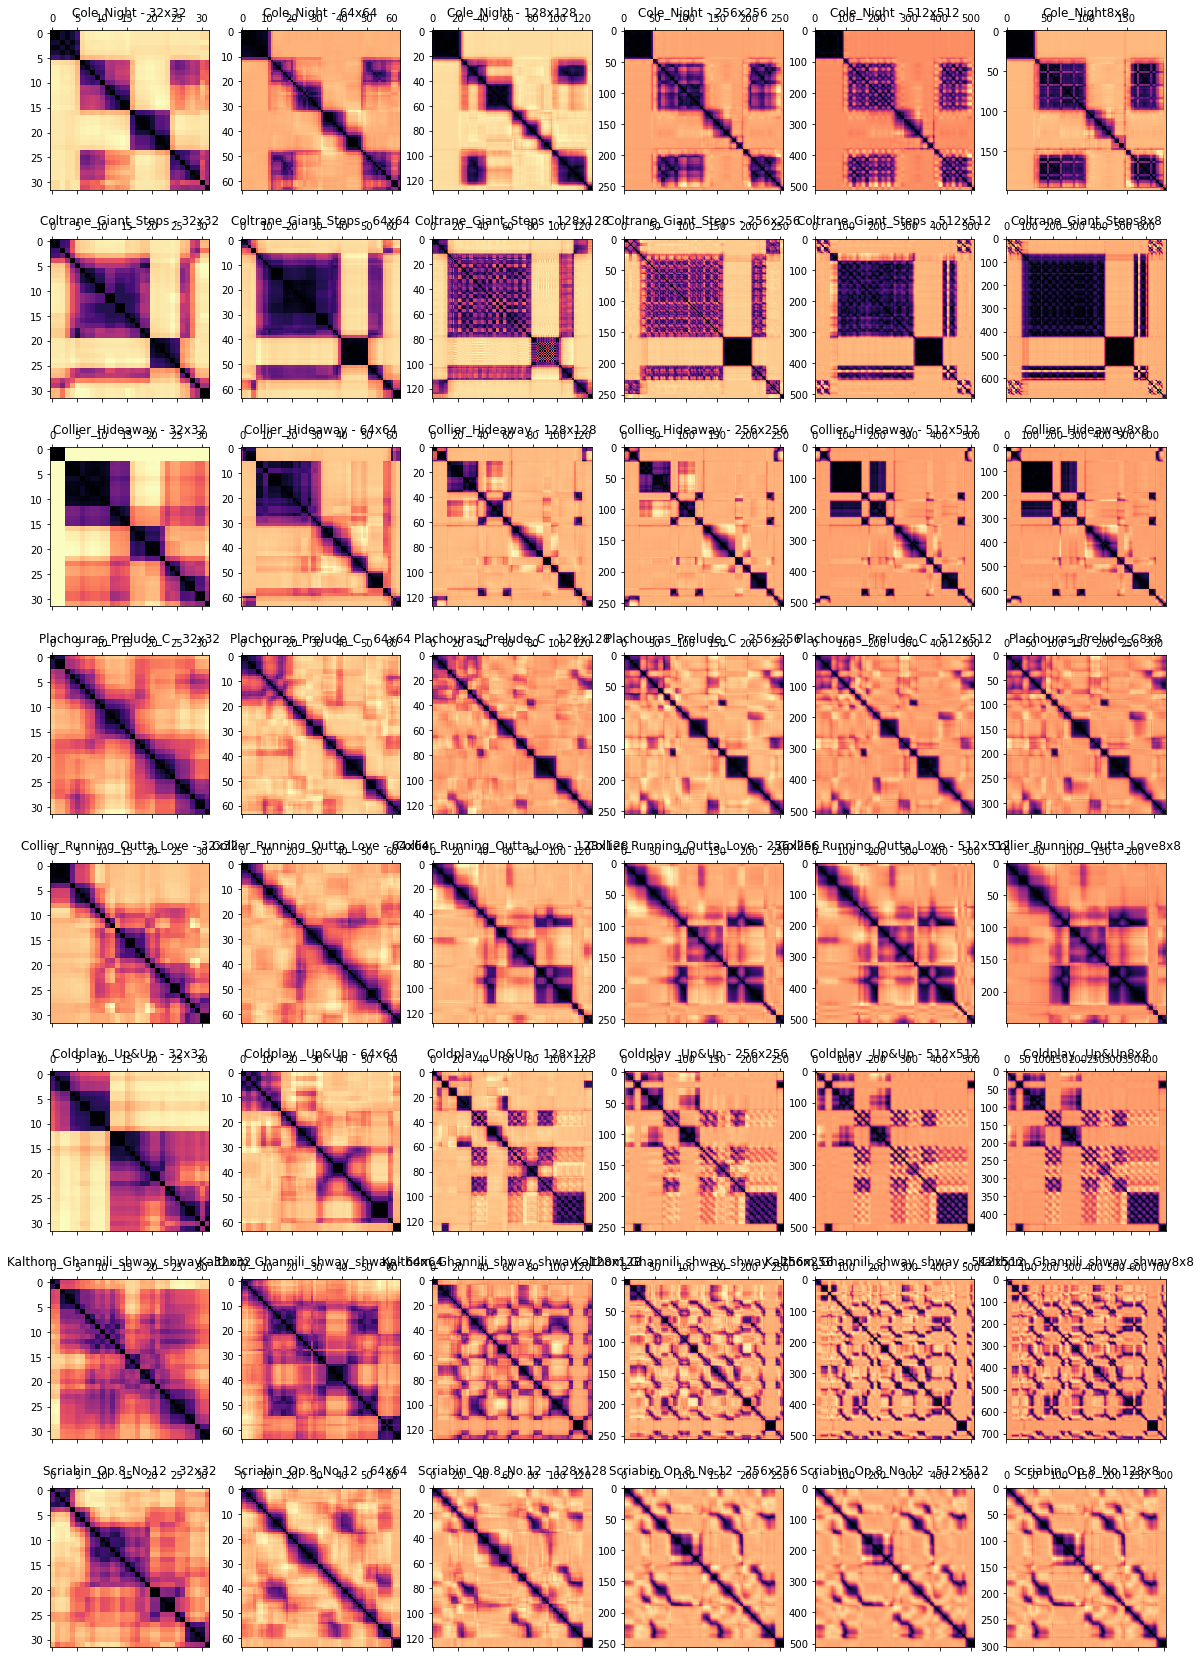

In [47]:
#Plotting original
plt.set_cmap('viridis')
fig, ax = plt.subplots(nrows=file_no, ncols=6, figsize=(20,30))
for i in range(file_no): 
    ax[i,0].matshow(X["D_d"]["logCQT_32"][i], cmap='magma')
    ax[i,0].set(title=all_names[i] + ' - 32x32')
    ax[i,1].matshow(X["D_d"]["logCQT_64"][i], cmap='magma')
    ax[i,1].set(title=all_names[i] + ' - 64x64')
    ax[i,2].matshow(X["D_d"]["logCQT_128"][i], cmap='magma')
    ax[i,2].set(title=all_names[i] + ' - 128x128')
    ax[i,3].matshow(X["D_d"]["logCQT_256"][i], cmap='magma')
    ax[i,3].set(title=all_names[i] + ' - 256x256')
    ax[i,4].matshow(X["D_d"]["logCQT_512"][i], cmap='magma')
    ax[i,4].set(title=all_names[i] + ' - 512x512')
    ax[i,5].matshow(X["D"]["logCQT"][i], cmap='magma')
    ax[i,5].set(title=all_names[i] + str(len(X["D"]["logCQT"])) + 'x' + str(len(X["D"]["logCQT"])))
